In [1]:
!pip install textblob torchmetrics


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import spacy
import random
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from torchmetrics import F1Score
from textblob import TextBlob
import matplotlib.pyplot as plt
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
from nltk.probability import FreqDist
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
seed = 2023

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Данные

## Считывание данных
[Fake and real news dataset](https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset)


In [4]:
df_false = pd.read_csv("Fake.csv")
df_true = pd.read_csv("True.csv")
df_false["label"] = 0
df_true["label"] = 1
df_true.head()

,title,text,subject,date,label
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


In [5]:
df_true.shape, df_false.shape

((21417, 5), (23481, 5))

In [6]:
df_false.head()

,title,text,subject,date,label
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017",0
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017",0
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017",0
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017",0
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017",0


In [7]:
# remove start words, because they are the same for true news
df_true["text"] = df_true["text"].apply(lambda x: x[x.find('Reuters)') + 11:])
df = pd.concat([df_true[:10000], df_false[:10000]], ignore_index=True)

In [8]:
df['data'] = df['text'] + " " + df['title']
df = df.drop(['date', 'subject', 'title', 'text'],axis=1)
df.head()

,label,data
0,1,The head of a conservative Republican faction ...
1,1,Transgender people will be allowed for the fir...
2,1,The special counsel investigation of links bet...
3,1,Trump campaign adviser George Papadopoulos tol...
4,1,President Donald Trump called on the U.S. Post...


## Предобработка

In [9]:
# works too long
#
# %%time
#
# lemmatizer = WordNetLemmatizer()
# stop_words = set(stopwords.words('english'))
#
# df['data'] = df['data'].apply(lambda x : [lemmatizer.lemmatize(str(TextBlob(token).correct()).lower())
#     for token in word_tokenize(x)])
# df['data'] = df['data'].apply(lambda x : [token for token in x if token not in stop_words])
# df.head()

In [10]:
%%time
# preprocessing by spacy takes about 1 hour for all dataset, so I took half of it

nlp = spacy.load("en_core_web_sm")
df['data'] = df['data'].apply(lambda x :[
        token.lemma_.lower() for token in nlp(x) if
        not token.is_stop
        and not token.is_punct
        and not token.is_digit
        and not token.like_email
        and not token.like_num
        and not token.is_space
    ])
df.head()

CPU times: total: 23min 43s
Wall time: 25min 29s


,label,data
0,1,"[head, conservative, republican, faction, u.s...."
1,1,"[transgender, people, allow, time, enlist, u.s..."
2,1,"[special, counsel, investigation, link, russia..."
3,1,"[trump, campaign, adviser, george, papadopoulo..."
4,1,"[president, donald, trump, call, u.s., postal,..."


In [11]:
X_train, X_test, y_train, y_test = train_test_split(df['data'], df['label'], test_size=0.20, random_state=seed)

## Составление словаря и превращение текста в эмбеддинги

In [12]:
train_corpus = list(X_train)
tokens = []
for text in tqdm(train_corpus):
  tokens.extend(text)
tokens_filtered = [word for word in tokens if word.isalnum()]

  0%|          | 0/16000 [00:00<?, ?it/s]

In [13]:
max_words = 10000
dist = FreqDist(tokens_filtered)
tokens_filtered_top = [pair[0] for pair in dist.most_common(max_words-1)]

In [14]:
tokens_filtered_top[:10]

['trump',
 'say',
 's',
 'president',
 't',
 'people',
 'donald',
 'republican',
 'house',
 'state']

In [15]:
vocabulary = {v: k for k, v in dict(enumerate(tokens_filtered_top, 1)).items()}

In [16]:
len(vocabulary)

9999

In [17]:
# Заполнение паддинга нулями
def text_to_sequence(tokens, maxlen):
    tokens_clean = [word for word in tokens if word.isalnum()]
    result = [vocabulary[word] for word in tokens_clean if word in vocabulary]
    padding = [0]*(maxlen-len(result))
    return padding + result[-maxlen:]

In [27]:
max_len = 300
x_train = np.array([text_to_sequence(text, max_len) for text in tqdm(X_train)], dtype=np.int32)
x_test = np.array([text_to_sequence(text, max_len) for text in tqdm(X_test)], dtype=np.int32)
y_train = np.array(y_train)
y_test = np.array(y_test)
x_train[:5,:]

  0%|          | 0/16000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

array([[ 488, 3799,    8, ...,  469,   42, 1547],
       [ 198,  451,  990, ...,   10,   36, 3050],
       [   0,    0,    0, ...,    7,    1, 2831],
       [ 772, 2807,  341, ...,  598, 7297,   56],
       [   0,    0,    0, ...,  150,  333, 3738]])

# Модели

## CNN Text Classification

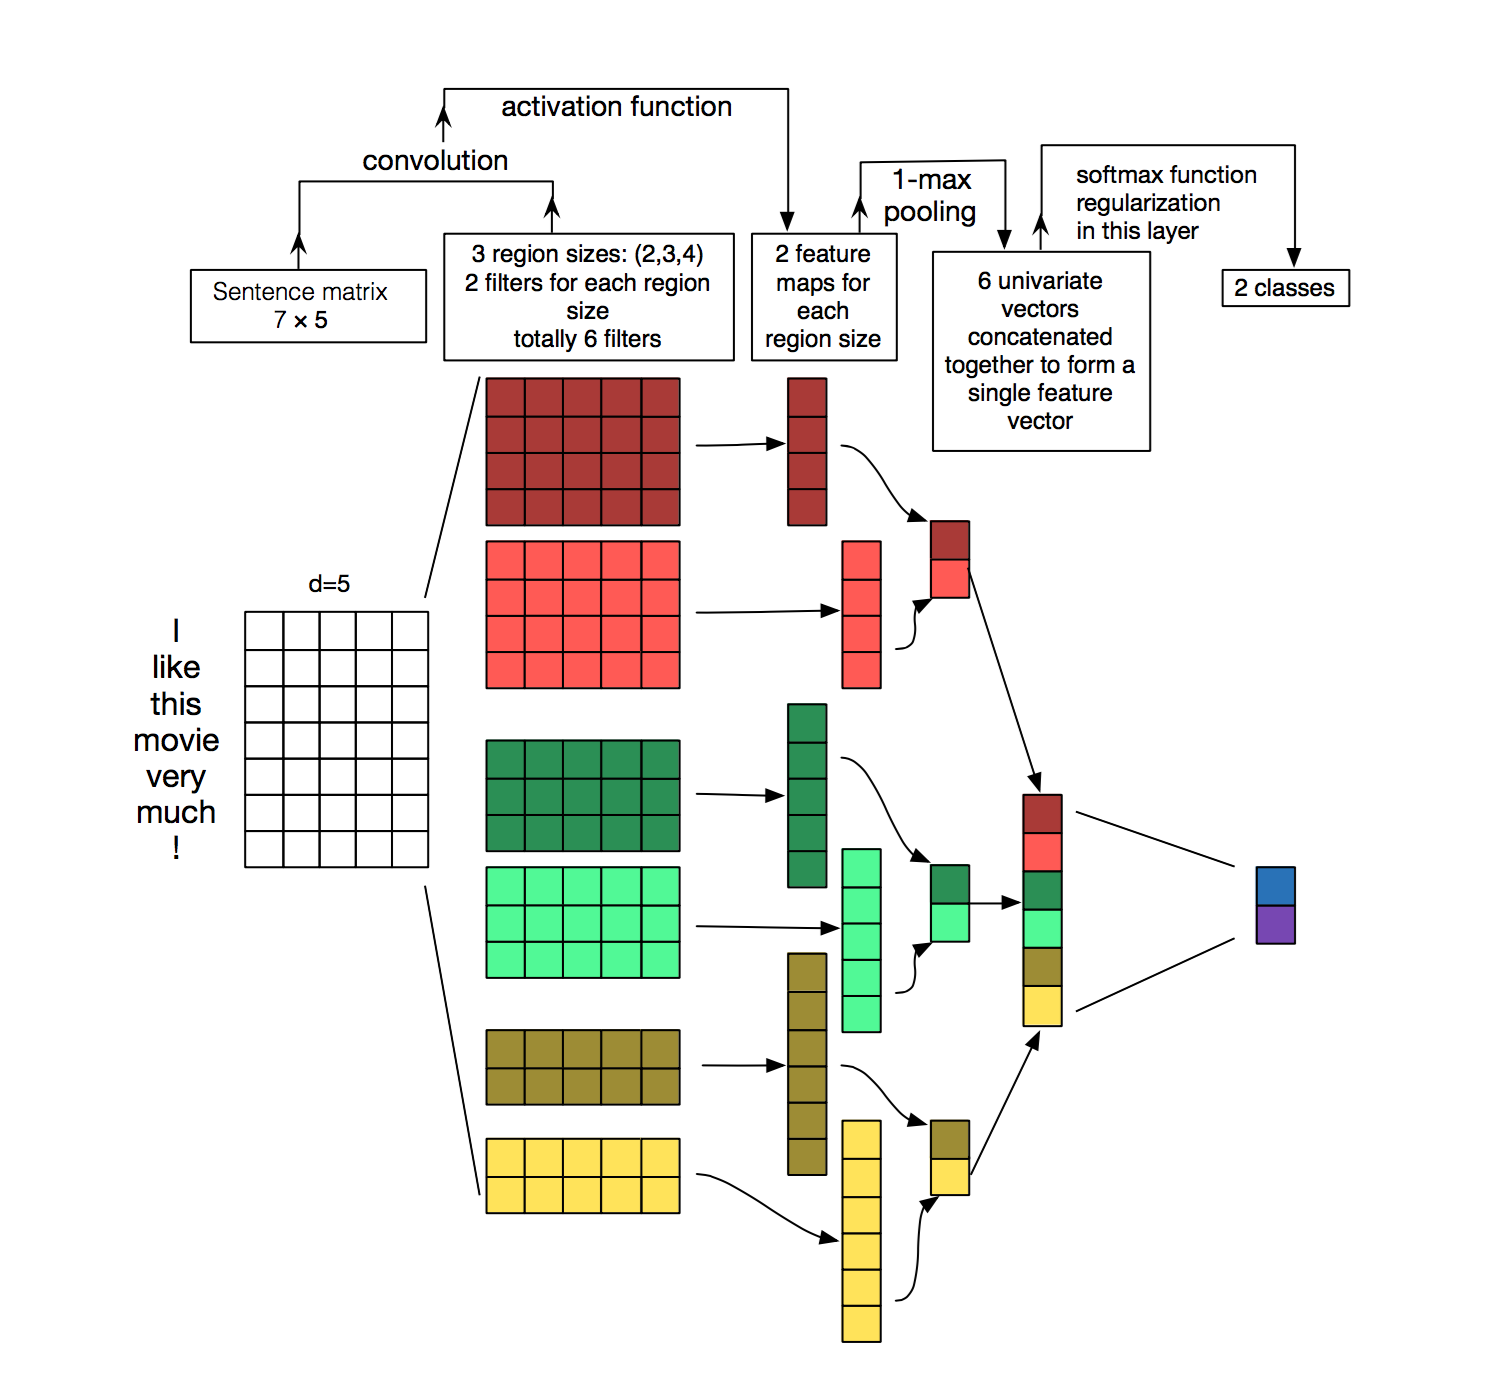

In [28]:
class ConvTextClassifier(nn.Module):
    def __init__(self, vocab_size=10000, embedding_dim=128, out_channel=128, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.conv = nn.Conv1d(embedding_dim, out_channel, kernel_size=3)
        self.relu = nn.ReLU()
        self.linear = nn.Linear(out_channel, num_classes)

    def forward(self, x):
        output = self.embedding(x)
        output = output.permute(0, 2, 1) # bs, emb_dim, len
        output = self.conv(output)
        output = self.relu(output)
        output = torch.max(output, axis=2).values
        output = self.linear(output)
        return output

In [29]:
class TextDataWrapper(Dataset):
    def __init__(self, data, target=None, transform=None):
        self.data = torch.from_numpy(data).long()
        if target is not None:
            self.target = torch.from_numpy(target).long()
        else:
          self.target = None
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.target[index] if self.target is not None else -1

        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.data)

## LSTM

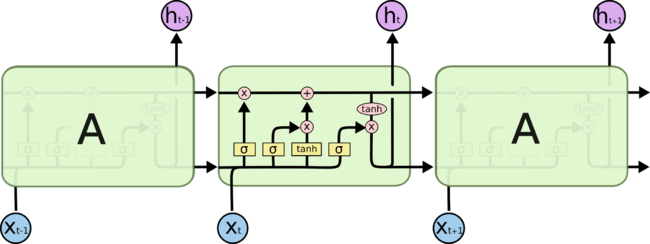

In [30]:
import torch.nn as nn

class LSTMTextClassifier(nn.Module):
    def __init__(self, vocab_size=10000, embedding_dim=128, hid_size=64, num_classes=2):
        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim)
        self.lstm = nn.LSTM(input_size=embedding_dim, hidden_size=hid_size, batch_first=True)
        self.linear = nn.Linear(in_features=hid_size, out_features=num_classes)

    def forward(self, x):
        out = self.embedding(x)
        out, _ = self.lstm(out)
        out = self.linear(out[:, -1, :])
        return out # output tensor should be of shape [batch_size, sequence_length, n_tokens]

## Обучение моделей

In [34]:
batch_size = 256
criterion = nn.CrossEntropyLoss()

In [35]:
def train_model(model, epochs):
    print(model)
    print("Parameters:", sum([param.nelement() for param in model.parameters()]))

    model.train()
    f1 = F1Score(task="binary")
    optimizer = torch.optim.Adam(model.parameters(), lr=10e-3)

    train_dataset = TextDataWrapper(x_train, y_train)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    loss_history = []
    for epoch in range(1,epochs+1):
        print(f"Train epoch {epoch}/{epochs}")
        temp_loss = []
        temp_metrics = []
        for i, (data, target) in enumerate(train_loader):
            optimizer.zero_grad()

            data = data
            target = target
            output = model(data)

            loss = criterion(output, target)
            loss.backward()

            optimizer.step()
            temp_loss.append(loss.float().item())
            temp_metrics.append(f1(output.argmax(1), target).item())

        epoch_loss = np.array(temp_loss).mean()
        epoch_f1 = np.array(temp_metrics).mean()
        print(f'Loss: {epoch_loss}, f1 score: {epoch_f1}')
        loss_history.append(epoch_loss)

    plt.title('Loss history')
    plt.grid(True)
    plt.ylabel('Train loss')
    plt.xlabel('Step')
    plt.plot(loss_history)
    return model

ConvTextClassifier(
  (embedding): Embedding(10000, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
Parameters: 1329538
Train epoch 1/5
Loss: 0.11720166363525167, f1 score: 0.9588854019604032
Train epoch 2/5
Loss: 0.003304648768775339, f1 score: 0.9992037103289649
Train epoch 3/5
Loss: 0.00027396630436655073, f1 score: 1.0
Train epoch 4/5
Loss: 0.00014769698365911147, f1 score: 1.0
Train epoch 5/5
Loss: 0.00010161375099587964, f1 score: 1.0
CPU times: total: 6min 54s
Wall time: 1min 50s


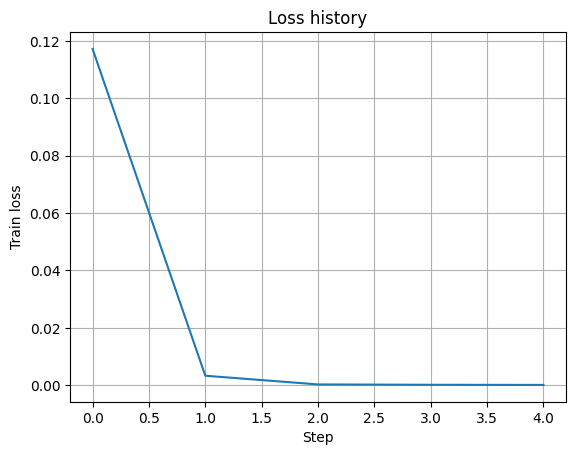

In [36]:
%%time
cnn_model = train_model(ConvTextClassifier(), 5)

LSTMTextClassifier(
  (embedding): Embedding(10000, 128)
  (lstm): LSTM(128, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Parameters: 1329794
Train epoch 1/10
Loss: 0.18812811073093189, f1 score: 0.923952891713097
Train epoch 2/10
Loss: 0.06550998169751394, f1 score: 0.9809376162195963
Train epoch 3/10
Loss: 0.11241984664506856, f1 score: 0.968222561336699
Train epoch 4/10
Loss: 0.008907772166403158, f1 score: 0.9977962090855553
Train epoch 5/10
Loss: 0.002397887381939365, f1 score: 0.9996210119080922
Train epoch 6/10
Loss: 0.0009954823901699413, f1 score: 0.9999382372886415
Train epoch 7/10
Loss: 0.0006656417579737506, f1 score: 0.9999391833941141
Train epoch 8/10
Loss: 0.0004914873418220807, f1 score: 0.9999372609077938
Train epoch 9/10
Loss: 0.0004020112408195726, f1 score: 0.999943512772757
Train epoch 10/10
Loss: 0.0003478020297489055, f1 score: 0.9999352125894456
CPU times: total: 22min 28s
Wall time: 5min 49s


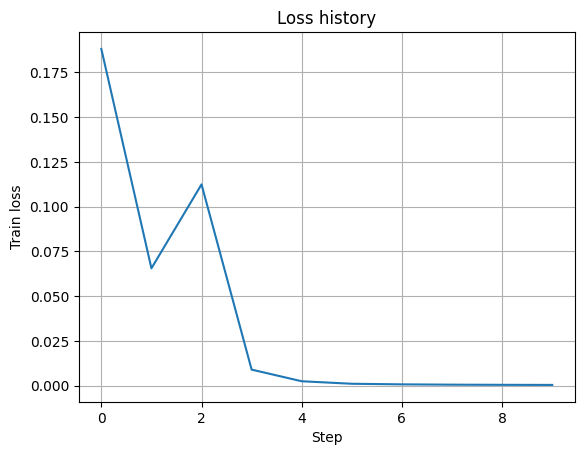

In [42]:
%%time
lstm_model = train_model(LSTMTextClassifier(), 10)

Запустим на тестовой выборке

In [43]:
test_dataset = TextDataWrapper(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [44]:
def evaluate(model, dataloader):
    model.eval() # == model.train(False)
    total_loss = 0
    predictions, targets = [], []

    with torch.no_grad():
        for i, (data, target) in enumerate(dataloader):
            output = model(data)
            loss = criterion(output, target)
            total_loss += loss.item()
            prediction = output.argmax(dim=1)
            predictions.extend(prediction.cpu().numpy())
            targets.extend(target.cpu().numpy())
    print(model)
    print("Average loss:", total_loss/len(dataloader))
    print("F1 score:", f1_score(targets, predictions, average='binary'))

In [45]:
evaluate(cnn_model, test_loader)

ConvTextClassifier(
  (embedding): Embedding(10000, 128)
  (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
  (relu): ReLU()
  (linear): Linear(in_features=128, out_features=2, bias=True)
)
Average loss: 0.009159366373751254
F1 score: 0.9984947315604615


In [46]:
evaluate(lstm_model, test_loader)

LSTMTextClassifier(
  (embedding): Embedding(10000, 128)
  (lstm): LSTM(128, 64, batch_first=True)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)
Average loss: 0.010213847877821536
F1 score: 0.9972368751569957


Видно, что LSTM отработала примерно так же хорошо, как и CNN, но при этом ей потребовалось больше времени на обучение.